In [1]:
from google.colab import drive 
drive.mount("/content/gdrive")  

Mounted at /content/gdrive


**IMPORTING LIBRARIES**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
df = pd.read_csv("gdrive/My Drive/phytoplantkon.csv")

**SETTING THE HEADER**
* SETTING UP BODY

In [3]:
new_header = df.iloc[0] # grab the first row for the header
df= df[1:] #take the data less the header row
df.columns = new_header #set the header row 
df= df[:828] 


**DATA CLEANING**

In [4]:
### DATA CLEANING 
def clean_data(df): 
  df["Alexandrium spp. \ncells L-1\n(PSP)"] = df["Alexandrium spp. \ncells L-1\n(PSP)"].replace("ND", 0) 
  df["Pseudo-nitzschia spp. \ncells L-1\n(ASP) "] = df["Pseudo-nitzschia spp. \ncells L-1\n(ASP) "].replace("ND", 0) 
  df["Dinophysiaceae \ncells L-1\n(DSP)"] = df["Dinophysiaceae \ncells L-1\n(DSP)"].replace("ND", 0) 
  df["Prorocentrum lima \ncells L-1\n(DSP)"] = df["Prorocentrum lima \ncells L-1\n(DSP)"].replace("ND", 0)   
   
  df["Alexandrium spp. \ncells L-1\n(PSP)"] = pd.to_numeric(df["Alexandrium spp. \ncells L-1\n(PSP)"], errors='coerce') 
  df["Pseudo-nitzschia spp. \ncells L-1\n(ASP) "] = pd.to_numeric(df["Pseudo-nitzschia spp. \ncells L-1\n(ASP) "], errors='coerce')      
  df["Dinophysiaceae \ncells L-1\n(DSP)"] = pd.to_numeric(df["Dinophysiaceae \ncells L-1\n(DSP)"], errors='coerce')      
  df["Prorocentrum lima \ncells L-1\n(DSP)"] = pd.to_numeric(df["Prorocentrum lima \ncells L-1\n(DSP)"], errors='coerce')
  
  df["Alexandrium spp. \ncells L-1\n(PSP)"] = df["Alexandrium spp. \ncells L-1\n(PSP)"].fillna(-1) 
  df["Pseudo-nitzschia spp. \ncells L-1\n(ASP) "] = df["Pseudo-nitzschia spp. \ncells L-1\n(ASP) "].fillna(-1) 
  df["Dinophysiaceae \ncells L-1\n(DSP)"] = df["Dinophysiaceae \ncells L-1\n(DSP)"].fillna(-1) 
  df["Prorocentrum lima \ncells L-1\n(DSP)"] = df["Prorocentrum lima \ncells L-1\n(DSP)"].fillna(-1)

In [5]:
clean_data(df)

**SETTING THRESHOLD**

In [6]:
thresholds = {"Alexandrium spp. \ncells L-1\n(PSP)" : 40, "Dinophysiaceae \ncells L-1\n(DSP)" : 100, "Prorocentrum lima \ncellsL-1\n(DSP)" : 100, "Pseudo-nitzschia spp. \ncells L-1\n(ASP) " : 150000}

In [7]:
def check_thresholds(df): 
  t = [] 
  for i,j in enumerate(df["Sample number"]): 
     
    alexandrium = df.iloc[i]["Alexandrium spp. \ncells L-1\n(PSP)"]    
    pseudo_nitzschia = df.iloc[i]['Pseudo-nitzschia spp. \ncells L-1\n(ASP) '] 
    dinophysiaceae = df.iloc[i]["Dinophysiaceae \ncells L-1\n(DSP)"] 
    prorocentrum = df.iloc[i]["Prorocentrum lima \ncells L-1\n(DSP)"]

    threshold_reached = 0 
    if pseudo_nitzschia >= thresholds['Pseudo-nitzschia spp. \ncells L-1\n(ASP) ']: 
      threshold_reached = 1 
    elif dinophysiaceae >= thresholds["Dinophysiaceae \ncells L-1\n(DSP)"]:
      threshold_reached = 1 
    elif prorocentrum >= thresholds["Prorocentrum lima \ncellsL-1\n(DSP)"]: 
      threshold_reached = 1                
    elif alexandrium >= thresholds["Alexandrium spp. \ncells L-1\n(PSP)"]: 
      threshold_reached = 1                
       
    t.append(threshold_reached) 
     
  return t 

In [8]:
  thresholds_reached = check_thresholds(df)
  df['thresholds_reached'] = thresholds_reached


In [9]:
my_list= []
for i in df["thresholds_reached"]:
  if i == 0 or i ==1:
    my_list.append(i)
print(len(my_list))



828


In [10]:
df["thresholds_reached"].value_counts()

0    733
1     95
Name: thresholds_reached, dtype: int64

**WRITING TO SAVE CLEAN DATA TO CSV**

In [11]:
  pd.DataFrame.to_csv(df, 'gdrive/My Drive/thresholds_cleaned.csv', sep=',', index=False)

READING INPUT AND OUTPUT DATA

In [12]:
x = pd.read_csv('gdrive/My Drive/thresholds_cleaned.csv', usecols=["Pseudo-nitzschia spp. \ncells L-1\n(ASP) ", "Dinophysiaceae \ncells L-1\n(DSP)", "Prorocentrum lima \ncells L-1\n(DSP)", "Alexandrium spp. \ncells L-1\n(PSP)"], na_values = ['no info', '.']) 
y = pd.read_csv('gdrive/My Drive/thresholds_cleaned.csv', usecols=["thresholds_reached"])

In [13]:
x.columns

Index(['Alexandrium spp. \ncells L-1\n(PSP)',
       'Dinophysiaceae \ncells L-1\n(DSP)',
       'Prorocentrum lima \ncells L-1\n(DSP)',
       'Pseudo-nitzschia spp. \ncells L-1\n(ASP) '],
      dtype='object')

In [14]:
y.columns

Index(['thresholds_reached'], dtype='object')

**Deep Learning**

In [15]:
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout 
from keras.optimizers import *
from keras.utils import np_utils

**Splitting my data into train and test**

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42,test_size=0.2)

In [17]:
print(len(y_train))
print(len(x_train))

662
662


In [18]:
print(len(x_test))
print(len(y_test))

166
166


**MODEL SETTING**

In [19]:
%%time
## MODEL 
model = Sequential() 
model.add(Dense(units=600, activation='relu', input_shape=(4,))) 
model.add(Dropout(0.9)) 
model.add(Dense(units=500, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(units=1, activation="relu")) 
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = model.fit(x_train,y_train, epochs=10,  verbose=1, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/10
42/42 [==============================] - 3s 9ms/step - loss: 2.4813 - accuracy: 0.8384 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 2/10
42/42 [==============================] - 0s 4ms/step - loss: 2.3023 - accuracy: 0.8489 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 3/10
42/42 [==============================] - 0s 4ms/step - loss: 2.0722 - accuracy: 0.8640 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 4/10
42/42 [==============================] - 0s 4ms/step - loss: 1.8397 - accuracy: 0.8807 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 5/10
42/42 [==============================] - 0s 4ms/step - loss: 1.8227 - accuracy: 0.8807 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 6/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 7/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 8/10
42/42 [==

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 600)               3000      
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               300500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 501       
                                                                 
Total params: 304,001
Trainable params: 304,001
Non-trainable params: 0
_________________________________________________________________


**Model evaluation**

In [21]:
score = model.evaluate(x_test,y_test)

6/6 [==============================] - 0s 3ms/step - loss: 1.6726 - accuracy: 0.8916


**Plotting Graphs**

In [22]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

In [23]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [24]:
def plot_graph(validation_data, training_data, graph_type):
    plt.clf()
    plt.figure(figsize=(6,6))
    epochs = range(1, len(training_data) + 1)
    plt.plot(epochs, training_data, 'g', label='Training '+graph_type)
    plt.plot(epochs, validation_data, 'b', label='Validation '+graph_type)
    plt.title('Training and validation '+graph_type)
    plt.xlabel('Epochs')
    plt.ylabel(graph_type)
    plt.legend()
    plt.show()


<Figure size 432x288 with 0 Axes>

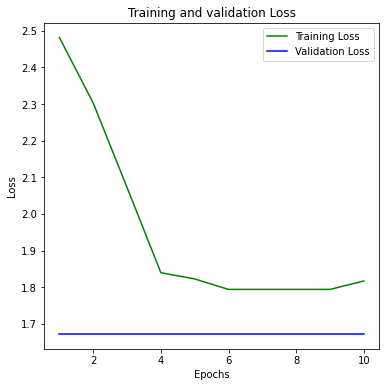

<Figure size 432x288 with 0 Axes>

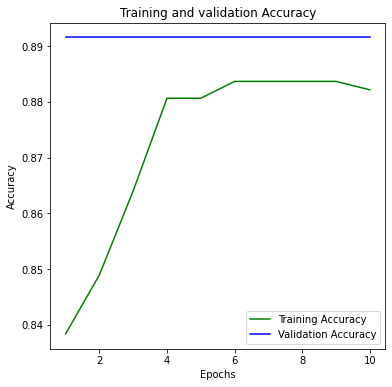

In [25]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy') 

# DATA AUGMENTATION

In [26]:
predictions = np.zeros(len(x_test))

In [27]:
print("Before OverSampling, counts of label '1': {}".format(sum(y["thresholds_reached"] == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y["thresholds_reached"] == 0)))

Before OverSampling, counts of label '1': 95
Before OverSampling, counts of label '0': 733 



In [28]:
## SMOTE
sm = SMOTE(random_state = 2)
x_train_res, y_train_res = sm.fit_resample(x, y["thresholds_reached"].ravel())

In [29]:
print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

After OverSampling, the shape of train_X: (1466, 4)
After OverSampling, the shape of train_y: (1466,) 



In [30]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After OverSampling, counts of label '1': 733
After OverSampling, counts of label '0': 733


In [31]:
from collections import Counter 
from sklearn.svm import LinearSVC 
from imblearn.pipeline import make_pipeline 
from imblearn.base import BaseSampler 
from imblearn.over_sampling import (SMOTE, RandomOverSampler) 
#!pip install imbalanced-learn 
import imblearn 
from imblearn.over_sampling import SMOTE

**DATA VISUALIZATION**

0                                          Alexandrium spp. \ncells L-1\n(PSP)  ...  thresholds_reached
0                                                                               ...                    
Alexandrium spp. \ncells L-1\n(PSP)                                   1.000000  ...            0.455902
Dinophysiaceae \ncells L-1\n(DSP)                                     0.055174  ...            0.461656
Prorocentrum lima \ncells L-1\n(DSP)                                 -0.008287  ...            0.140486
Pseudo-nitzschia spp. \ncells L-1\n(ASP)                              0.019008  ...            0.258077
NaN                                                                        NaN  ...                 NaN
NaN                                                                        NaN  ...                 NaN
thresholds_reached                                                    0.455902  ...            1.000000

[7 rows x 7 columns]


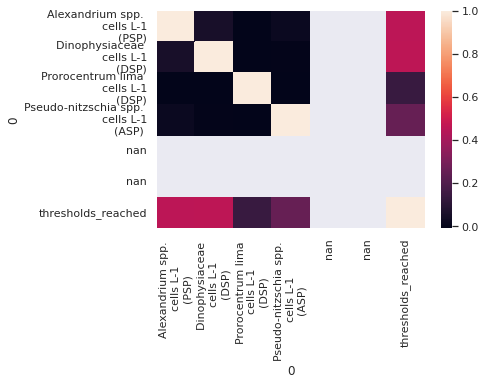

In [32]:
import numpy as np; np.random.seed(0) 
import seaborn as sns; sns.set_theme() 
corrMatrix = df.corr()
print (corrMatrix) 
ax = sns.heatmap(corrMatrix)

**FEEDING DATA AUGMENTATION INTO THE MODEL**

In [33]:
%%time 
## MODEL 
model = Sequential() 
model.add(Dense(units=1200, activation='relu', input_shape=(4,))) 
model.add(Dropout(0.9)) 
model.add(Dense(units=500, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(units=1, activation="relu")) 
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = model.fit(x_train_res,y_train_res, epochs=10,  verbose=1, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/10
92/92 [==============================] - 1s 5ms/step - loss: 5.7424 - accuracy: 0.6241 - val_loss: 6.8493 - val_accuracy: 0.5301
Epoch 2/10
92/92 [==============================] - 0s 3ms/step - loss: 4.4851 - accuracy: 0.7046 - val_loss: 7.3490 - val_accuracy: 0.5181
Epoch 3/10
92/92 [==============================] - 0s 4ms/step - loss: 4.5822 - accuracy: 0.7012 - val_loss: 1.1108 - val_accuracy: 0.9277
Epoch 4/10
92/92 [==============================] - 0s 4ms/step - loss: 4.7713 - accuracy: 0.6883 - val_loss: 1.0179 - val_accuracy: 0.9337
Epoch 5/10
92/92 [==============================] - 0s 4ms/step - loss: 5.4360 - accuracy: 0.6460 - val_loss: 1.1087 - val_accuracy: 0.9277
Epoch 6/10
92/92 [==============================] - 0s 4ms/step - loss: 4.8366 - accuracy: 0.6849 - val_loss: 0.9303 - val_accuracy: 0.9337
Epoch 7/10
92/92 [==============================] - 0s 4ms/step - loss: 4.4080 - accuracy: 0.7115 - val_loss: 1.1237 - val_accuracy: 0.9217
Epoch 8/10
92/92 [==

**model augmentation evaluation**

In [34]:
model.evaluate(x_test,y_test)

6/6 [==============================] - 0s 3ms/step - loss: 1.2037 - accuracy: 0.9217


[1.2037439346313477, 0.9216867685317993]

**After 6 epochs my model fail to increase and val accuracy and the val loss fail to decrease**

**PLotting Graphs of model with data augmentation**

In [35]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"] 

loss = history.history["loss"]
val_loss = history.history["val_loss"] 

In [36]:
def plot_graph(validation_data, training_data, graph_type):
    plt.clf()
    plt.figure(figsize=(6,6))
    epochs = range(1, len(training_data) + 1)
    plt.plot(epochs, training_data, 'g', label='Training '+graph_type)
    plt.plot(epochs, validation_data, 'b', label='Validation '+graph_type)
    plt.title('Training and validation '+graph_type)
    plt.xlabel('Epochs')
    plt.ylabel(graph_type)
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

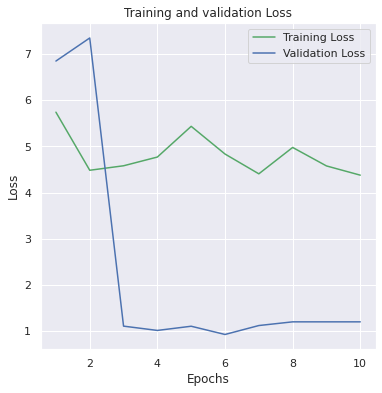

<Figure size 432x288 with 0 Axes>

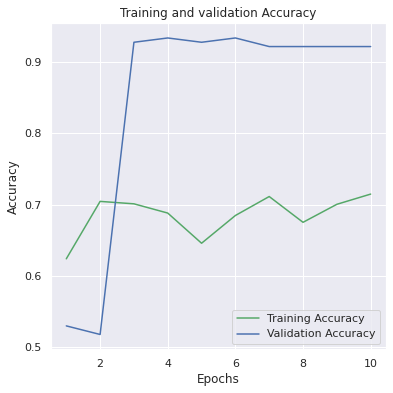

In [37]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy')

**Data Visualization**

0                                          Alexandrium spp. \ncells L-1\n(PSP)  ...  thresholds_reached
0                                                                               ...                    
Alexandrium spp. \ncells L-1\n(PSP)                                   1.000000  ...            0.455902
Dinophysiaceae \ncells L-1\n(DSP)                                     0.055174  ...            0.461656
Prorocentrum lima \ncells L-1\n(DSP)                                 -0.008287  ...            0.140486
Pseudo-nitzschia spp. \ncells L-1\n(ASP)                              0.019008  ...            0.258077
NaN                                                                        NaN  ...                 NaN
NaN                                                                        NaN  ...                 NaN
thresholds_reached                                                    0.455902  ...            1.000000

[7 rows x 7 columns]


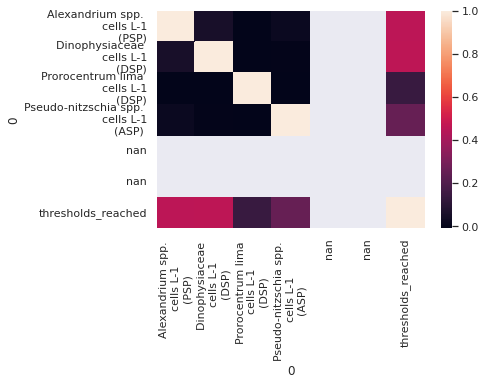

In [38]:
import numpy as np; np.random.seed(0) 
import seaborn as sns; sns.set_theme() 
corrMatrix = df.corr()
print (corrMatrix) 
ax = sns.heatmap(corrMatrix)

**Question 1**
• Specify the accuracy you achieved across 3 architectural modifications (e.g. different 
numbers of  layers, different hyperparameters, etc.)

* Hyper-parameter 1
* 3 HIDDEN LAYERS 
* 2 DROPOUTS 
* ACTIVATION FUNCTION = RELU
* LOSS FUNCTION = BINARY_CROSSENTROPY
* LAST LAYER ACTIVATION FUNCTION = TANH
* OPTIMIZER = RMSPROP

In [39]:
%%time 
## MODEL 1
model1 = Sequential()
model1.add(Dense(units=600, activation="relu",input_shape=(4,)))
model1.add(Dropout(0.5))
model1.add(Dense(units=340,activation="relu"))
model1.add(Dropout(0.3)) 
model1.add(Dense(1, activation="tanh"))
model1.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

history = model1.fit(x_train,y_train,epochs=10, verbose=1,batch_size=16,validation_data=(x_test,y_test))

Epoch 1/10
42/42 [==============================] - 1s 8ms/step - loss: 1.8082 - accuracy: 0.8807 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 2/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7595 - accuracy: 0.8852 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 3/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 4/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 5/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 6/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7708 - accuracy: 0.8852 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 7/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 8/10
42/42 [==

In [40]:
model1.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 600)               3000      
                                                                 
 dropout_4 (Dropout)         (None, 600)               0         
                                                                 
 dense_7 (Dense)             (None, 340)               204340    
                                                                 
 dropout_5 (Dropout)         (None, 340)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 341       
                                                                 
Total params: 207,681
Trainable params: 207,681
Non-trainable params: 0
_________________________________________________________________


**Model1 EVALUATION**

In [41]:
score1 = model1.evaluate(x_test,y_test) 

6/6 [==============================] - 0s 3ms/step - loss: 1.6726 - accuracy: 0.8916


**Plotting Model1 graph**

In [42]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"] 
val_loss = history.history["val_loss"]

<Figure size 432x288 with 0 Axes>

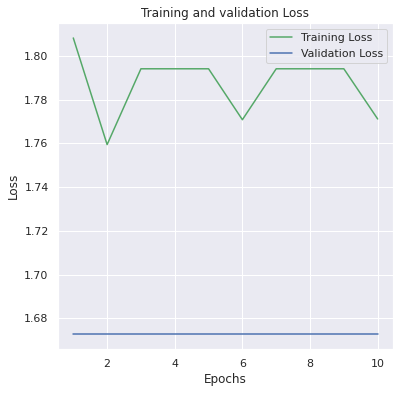

<Figure size 432x288 with 0 Axes>

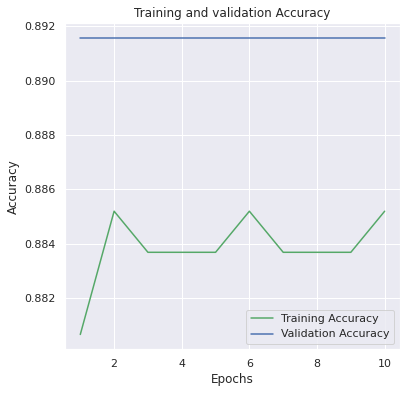

In [43]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy') 

In [44]:
%%time
## MODEL 1
model1 = Sequential()
model1.add(Dense(units=1200, activation="relu",input_shape=(4,)))
model1.add(Dropout(0.5))
model1.add(Dense(units=340,activation="relu"))
model1.add(Dropout(0.3)) 
model1.add(Dense(1, activation="tanh"))
model1.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

history = model1.fit(x_train_res,y_train_res,epochs=10, verbose=1,batch_size=16,validation_data=(x_test,y_test))

Epoch 1/10
92/92 [==============================] - 1s 5ms/step - loss: 5.2127 - accuracy: 0.6576 - val_loss: 7.3205 - val_accuracy: 0.5181
Epoch 2/10
92/92 [==============================] - 0s 4ms/step - loss: 4.4446 - accuracy: 0.7080 - val_loss: 7.2376 - val_accuracy: 0.5181
Epoch 3/10
92/92 [==============================] - 0s 4ms/step - loss: 6.0454 - accuracy: 0.6050 - val_loss: 1.4867 - val_accuracy: 0.9036
Epoch 4/10
92/92 [==============================] - 0s 4ms/step - loss: 6.2603 - accuracy: 0.5928 - val_loss: 1.4607 - val_accuracy: 0.9036
Epoch 5/10
92/92 [==============================] - 0s 4ms/step - loss: 5.9755 - accuracy: 0.6098 - val_loss: 1.4857 - val_accuracy: 0.9036
Epoch 6/10
92/92 [==============================] - 0s 4ms/step - loss: 5.8905 - accuracy: 0.6173 - val_loss: 0.9475 - val_accuracy: 0.9277
Epoch 7/10
92/92 [==============================] - 0s 4ms/step - loss: 5.9832 - accuracy: 0.6105 - val_loss: 1.4867 - val_accuracy: 0.9036
Epoch 8/10
92/92 [==

**MODEL EVALUATION**

In [45]:
model1.evaluate(x_test,y_test) 

6/6 [==============================] - 0s 3ms/step - loss: 0.8589 - accuracy: 0.9337


[0.8588865399360657, 0.9337349534034729]

**PLOTTING GRAPHS**

In [46]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"] 

In [47]:
def plot_graph(validation_data, training_data, graph_type):
    plt.clf()
    plt.figure(figsize=(6,6))
    epochs = range(1, len(training_data) + 1)
    plt.plot(epochs, training_data, 'g', label='Training '+graph_type)
    plt.plot(epochs, validation_data, 'b', label='Validation '+graph_type)
    plt.title('Training and validation '+graph_type)
    plt.xlabel('Epochs')
    plt.ylabel(graph_type)
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

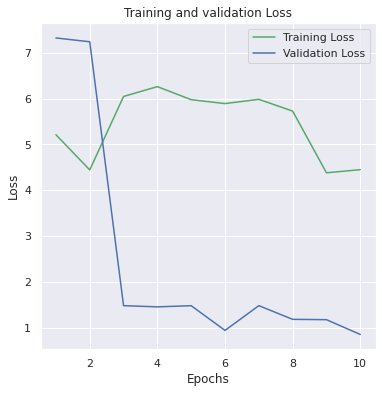

<Figure size 432x288 with 0 Axes>

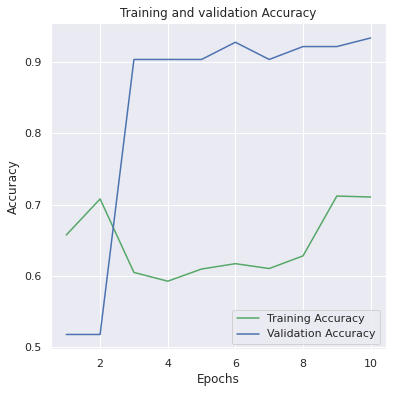

In [48]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy') 

**MODEL 2 HYPER-PARAMETER**
* 3 HIDDEN LAYERS
* 1 DROPOUT LAYER
* ACTIVATION FUNCTION = SIGMOID
* LAST LAYER ACTIVATION = RELU
* OPTIMIZER = ADAM
* LOSS FUNCTION = BINARY_CROSS ENTROPY

In [49]:
%%time 
model2 = Sequential()
model2.add(Dense(units=600, activation="sigmoid", input_shape=(4,)))
model2.add(Dropout(0.9))
model2.add(Dense(units=300, activation="sigmoid"))
model2.add(Dense(200, activation="sigmoid")) 
model2.add(Dense(units=1, activation="relu")) 
model2.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

history = model2.fit(x_train,y_train,verbose=1,epochs=10,batch_size=16,validation_data=(x_test,y_test))


Epoch 1/10
42/42 [==============================] - 1s 7ms/step - loss: 1.9409 - accuracy: 0.8082 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 2/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 3/10
42/42 [==============================] - 0s 5ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 4/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 5/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 6/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 7/10
42/42 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.8837 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 8/10
42/42 [==

In [50]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 600)               3000      
                                                                 
 dropout_8 (Dropout)         (None, 600)               0         
                                                                 
 dense_13 (Dense)            (None, 300)               180300    
                                                                 
 dense_14 (Dense)            (None, 200)               60200     
                                                                 
 dense_15 (Dense)            (None, 1)                 201       
                                                                 
Total params: 243,701
Trainable params: 243,701
Non-trainable params: 0
_________________________________________________________________


**MODEL 2 EVALUATE**

In [51]:
model2.evaluate(x_test,y_test)

6/6 [==============================] - 0s 3ms/step - loss: 1.6726 - accuracy: 0.8916


[1.6725847721099854, 0.891566276550293]

**Plotting Graph**

In [52]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

<Figure size 432x288 with 0 Axes>

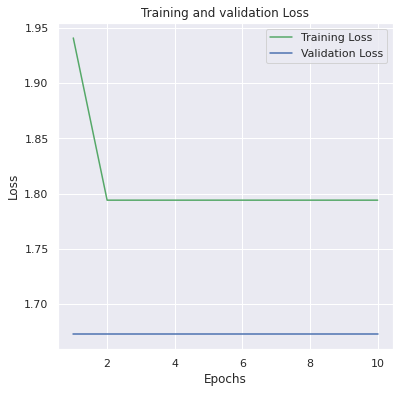

<Figure size 432x288 with 0 Axes>

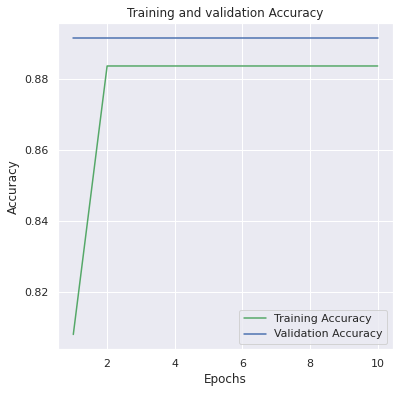

In [53]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy') 

**FEEDING THE DATA AUGMENTATION INTO MODEL 2**

In [54]:
%%time
model2 = Sequential()
model2.add(Dense(units=1200, activation="sigmoid", input_shape=(4,)))
model2.add(Dropout(0.9))
model2.add(Dense(units=300, activation="sigmoid"))
model2.add(Dense(200, activation="sigmoid"))
model2.add(Dense(units=1, activation="relu")) 
model2.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

history = model2.fit(x_train_res,y_train_res,verbose=1,epochs=10,batch_size=16,validation_data=(x_test,y_test))

Epoch 1/10
92/92 [==============================] - 1s 5ms/step - loss: 1.5521 - accuracy: 0.6521 - val_loss: 0.4172 - val_accuracy: 0.9277
Epoch 2/10
92/92 [==============================] - 0s 3ms/step - loss: 2.6713 - accuracy: 0.6978 - val_loss: 0.9399 - val_accuracy: 0.9277
Epoch 3/10
92/92 [==============================] - 0s 3ms/step - loss: 6.2498 - accuracy: 0.5587 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 4/10
92/92 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 5/10
92/92 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 6/10
92/92 [==============================] - 0s 4ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 7/10
92/92 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 1.6726 - val_accuracy: 0.8916
Epoch 8/10
92/92 [==

**MODEL EVALUATION**

In [55]:
model2.evaluate(x_test,y_test) 

6/6 [==============================] - 0s 3ms/step - loss: 1.6726 - accuracy: 0.8916


[1.6725847721099854, 0.891566276550293]

**PLOTTING GRAPH**

In [56]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

<Figure size 432x288 with 0 Axes>

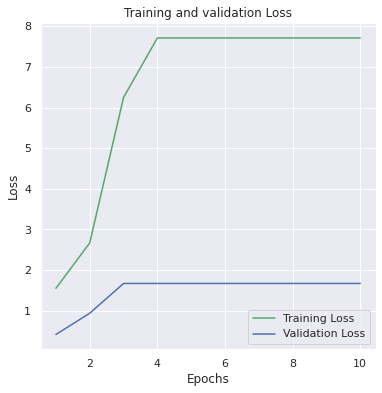

<Figure size 432x288 with 0 Axes>

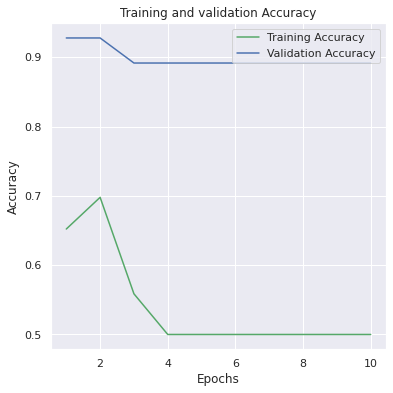

In [57]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy') 

**Model3 HYPER-PARAMETER**
* 3 HIDDEN LAYERS
* 2 DROPOUT LAYER
* LOSS FUNCTION = BINARY_CROSSENTROPY
* ACTIVATION FUNCTION = SIGMOID
* LAST LAYER ACTIVATION = SIGMOID
* OPTIMIZER = ADAM


In [58]:
%%time
model3=Sequential()
model3.add(Dense(units=600, activation="sigmoid",input_shape=(4,)))
model.add(Dropout(0.6))
model3.add(Dense(units=80,activation="sigmoid"))
model3.add(Dropout(0.5))
model3.add(Dense(1,activation="sigmoid"))

model3.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

history = model3.fit(x_train,y_train,verbose=1,epochs=10,batch_size=16,validation_data=(x_test,y_test))  
 

Epoch 1/10
42/42 [==============================] - 1s 6ms/step - loss: 0.3750 - accuracy: 0.8580 - val_loss: 0.2515 - val_accuracy: 0.9277
Epoch 2/10
42/42 [==============================] - 0s 3ms/step - loss: 0.2676 - accuracy: 0.9003 - val_loss: 0.1905 - val_accuracy: 0.9458
Epoch 3/10
42/42 [==============================] - 0s 4ms/step - loss: 0.2126 - accuracy: 0.9335 - val_loss: 0.1931 - val_accuracy: 0.9337
Epoch 4/10
42/42 [==============================] - 0s 3ms/step - loss: 0.1851 - accuracy: 0.9456 - val_loss: 0.1634 - val_accuracy: 0.9337
Epoch 5/10
42/42 [==============================] - 0s 3ms/step - loss: 0.1853 - accuracy: 0.9502 - val_loss: 0.1634 - val_accuracy: 0.9337
Epoch 6/10
42/42 [==============================] - 0s 4ms/step - loss: 0.1664 - accuracy: 0.9517 - val_loss: 0.1500 - val_accuracy: 0.9458
Epoch 7/10
42/42 [==============================] - 0s 5ms/step - loss: 0.1690 - accuracy: 0.9471 - val_loss: 0.1581 - val_accuracy: 0.9398
Epoch 8/10
42/42 [==

In [59]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 600)               3000      
                                                                 
 dense_21 (Dense)            (None, 80)                48080     
                                                                 
 dropout_11 (Dropout)        (None, 80)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 81        
                                                                 
Total params: 51,161
Trainable params: 51,161
Non-trainable params: 0
_________________________________________________________________


**MODEL 3 EVALUATTION**

In [60]:
score = model3.evaluate(x_test,y_test,verbose=0)
score 

[0.1359192281961441, 0.9638554453849792]

**PLOTTING GRAPHS**

In [61]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

<Figure size 432x288 with 0 Axes>

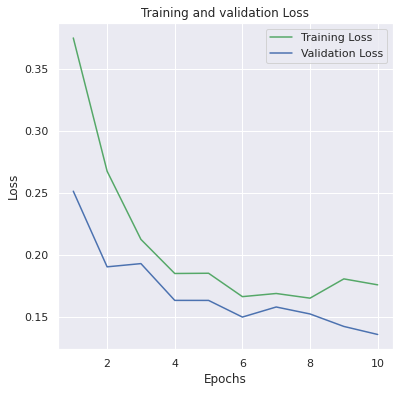

<Figure size 432x288 with 0 Axes>

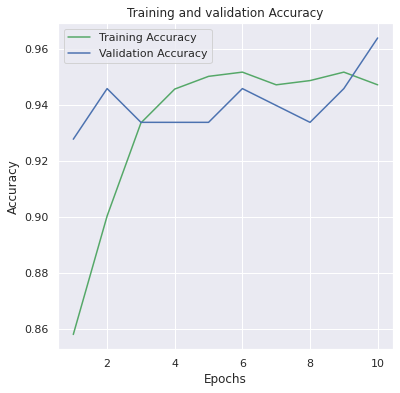

In [62]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy')

**FEEDING DATA AUGEMTANTION TO MODEL 3**

In [63]:
%%time
model3=Sequential()
model3.add(Dense(units=1200, activation="sigmoid",input_shape=(4,)))
model.add(Dropout(0.6))
model3.add(Dense(units=80,activation="sigmoid"))
model3.add(Dropout(0.5))
model3.add(Dense(1,activation="sigmoid"))

model3.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

history = model3.fit(x_train_res,y_train_res,verbose=1,epochs=10,batch_size=16,validation_data=(x_test,y_test))  

Epoch 1/10
92/92 [==============================] - 2s 8ms/step - loss: 0.4449 - accuracy: 0.7647 - val_loss: 0.2047 - val_accuracy: 0.9277
Epoch 2/10
92/92 [==============================] - 0s 5ms/step - loss: 0.3323 - accuracy: 0.8336 - val_loss: 0.1676 - val_accuracy: 0.9337
Epoch 3/10
92/92 [==============================] - 0s 3ms/step - loss: 0.3141 - accuracy: 0.8506 - val_loss: 0.2525 - val_accuracy: 0.9518
Epoch 4/10
92/92 [==============================] - 0s 3ms/step - loss: 0.2893 - accuracy: 0.8568 - val_loss: 0.2248 - val_accuracy: 0.9337
Epoch 5/10
92/92 [==============================] - 0s 3ms/step - loss: 0.3029 - accuracy: 0.8452 - val_loss: 0.3651 - val_accuracy: 0.6988
Epoch 6/10
92/92 [==============================] - 0s 3ms/step - loss: 0.2829 - accuracy: 0.8581 - val_loss: 0.1707 - val_accuracy: 0.9518
Epoch 7/10
92/92 [==============================] - 0s 3ms/step - loss: 0.2845 - accuracy: 0.8561 - val_loss: 0.2484 - val_accuracy: 0.9518
Epoch 8/10
92/92 [==

**MODEL EVALUATION**

In [64]:
model3.evaluate(x_test,y_test,verbose=0)

[0.15560919046401978, 0.9638554453849792]

**PLOTTING GRAPH**

<Figure size 432x288 with 0 Axes>

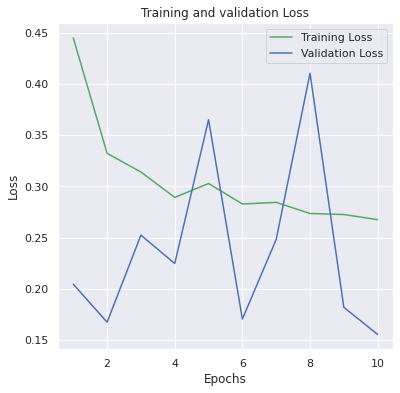

<Figure size 432x288 with 0 Axes>

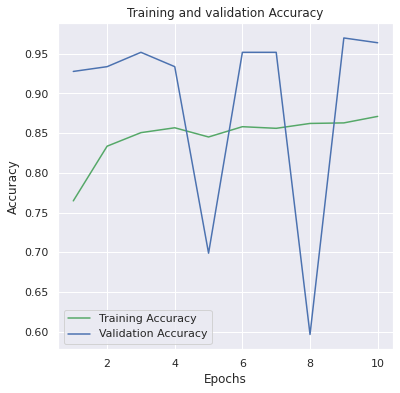

In [65]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy')

**What happens if  you include more than 4 (hidden) layers? **
* 6 HIDDEN LAYER
* 3 DROPOUT LAYER
* ACTIVATION FUNCTION = SIGMOID
* LOSS FUNCTION = BINARY_CROSSENTROPY
* OPTIMIZER =ADAM

In [66]:
%%time
model4 = Sequential()
model4.add(Dense(units=650, activation="sigmoid",input_shape=(4,))) #Input layer
model4.add(Dropout(0.3))
model4.add(Dense(units=500, activation="sigmoid"))
model4.add(Dropout(0.2)) 
model4.add(Dense(units=350,activation="sigmoid")) 
model4.add(Dropout(0.5))
model4.add(Dense(units=60,activation="sigmoid"))
model4.add(Dense(units=1,activation="sigmoid"))  # outter layer

model4.compile(loss="binary_crossentropy",optimizer="Adam",metrics=["accuracy"])

history = model4.fit(x_train,y_train, verbose=1, epochs=10, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/10
42/42 [==============================] - 1s 9ms/step - loss: 0.3771 - accuracy: 0.8837 - val_loss: 0.3392 - val_accuracy: 0.8916
Epoch 2/10
42/42 [==============================] - 0s 4ms/step - loss: 0.3197 - accuracy: 0.8852 - val_loss: 0.2140 - val_accuracy: 0.9458
Epoch 3/10
42/42 [==============================] - 0s 4ms/step - loss: 0.2095 - accuracy: 0.9335 - val_loss: 0.1747 - val_accuracy: 0.9578
Epoch 4/10
42/42 [==============================] - 0s 4ms/step - loss: 0.1794 - accuracy: 0.9471 - val_loss: 0.1589 - val_accuracy: 0.9398
Epoch 5/10
42/42 [==============================] - 0s 4ms/step - loss: 0.1685 - accuracy: 0.9547 - val_loss: 0.1555 - val_accuracy: 0.9458
Epoch 6/10
42/42 [==============================] - 0s 4ms/step - loss: 0.1731 - accuracy: 0.9456 - val_loss: 0.1487 - val_accuracy: 0.9578
Epoch 7/10
42/42 [==============================] - 0s 4ms/step - loss: 0.1615 - accuracy: 0.9502 - val_loss: 0.1264 - val_accuracy: 0.9578
Epoch 8/10
42/42 [==

**MODEL4 EVALUATION**

In [67]:
score = model4.evaluate(x_test,y_test)
score 

6/6 [==============================] - 0s 3ms/step - loss: 0.1364 - accuracy: 0.9639


[0.13643017411231995, 0.9638554453849792]

**PLOTTING GRAPHS**

In [68]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

<Figure size 432x288 with 0 Axes>

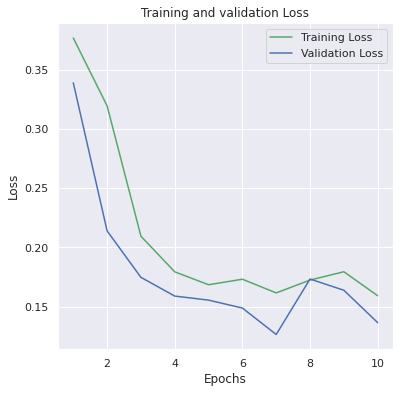

<Figure size 432x288 with 0 Axes>

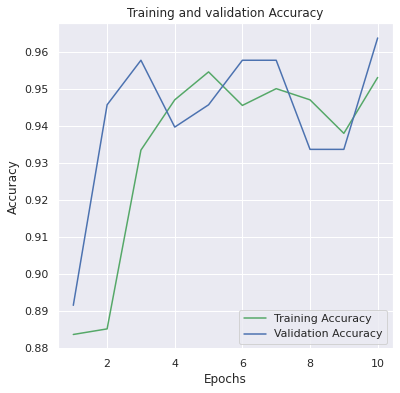

In [69]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy')

**DATA AUGMENTATION**

In [70]:
%%time
model4 = Sequential()
model4.add(Dense(units=1200, activation="sigmoid",input_shape=(4,))) #Input layer
model4.add(Dropout(0.3))
model4.add(Dense(units=500, activation="sigmoid"))
model4.add(Dropout(0.2))
model4.add(Dense(units=350,activation="sigmoid"))
model4.add(Dropout(0.5))  
model4.add(Dense(units=60,activation="sigmoid"))
model4.add(Dense(units=1,activation="sigmoid"))  # outter layer

model4.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

history = model4.fit(x_train_res,y_train_res, verbose=1, epochs=10, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/10
92/92 [==============================] - 1s 6ms/step - loss: 0.4745 - accuracy: 0.7592 - val_loss: 0.2682 - val_accuracy: 0.9578
Epoch 2/10
92/92 [==============================] - 0s 4ms/step - loss: 0.3193 - accuracy: 0.8431 - val_loss: 0.1520 - val_accuracy: 0.9578
Epoch 3/10
92/92 [==============================] - 0s 4ms/step - loss: 0.3111 - accuracy: 0.8349 - val_loss: 0.2008 - val_accuracy: 0.9458
Epoch 4/10
92/92 [==============================] - 0s 4ms/step - loss: 0.2983 - accuracy: 0.8458 - val_loss: 0.2530 - val_accuracy: 0.9819
Epoch 5/10
92/92 [==============================] - 0s 4ms/step - loss: 0.2923 - accuracy: 0.8479 - val_loss: 0.1627 - val_accuracy: 0.9518
Epoch 6/10
92/92 [==============================] - 0s 4ms/step - loss: 0.2898 - accuracy: 0.8486 - val_loss: 0.2007 - val_accuracy: 0.9639
Epoch 7/10
92/92 [==============================] - 0s 4ms/step - loss: 0.2900 - accuracy: 0.8595 - val_loss: 0.2630 - val_accuracy: 0.9639
Epoch 8/10
92/92 [==

**Model evaluation**

In [71]:
model4.evaluate(x_test,y_test) 

6/6 [==============================] - 0s 3ms/step - loss: 0.1570 - accuracy: 0.9699


[0.15699540078639984, 0.9698795080184937]

In [72]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

**GRAPHS**

<Figure size 432x288 with 0 Axes>

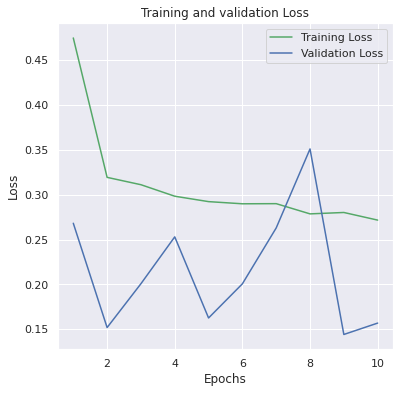

<Figure size 432x288 with 0 Axes>

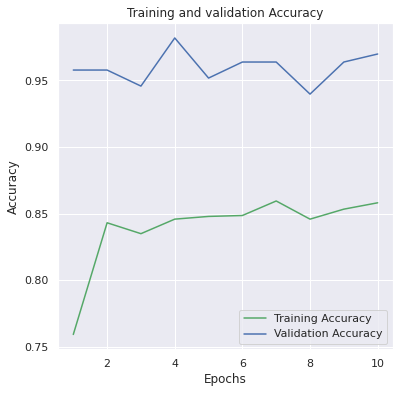

In [73]:
plot_graph(history.history['val_loss'], history.history['loss'], 'Loss')
plot_graph(history.history['val_accuracy'], history.history['accuracy'], 'Accuracy')

**CORRELATION AND HEATMAP**

Text(0.5, 1.0, 'Heatmap of phytoplankton data correlation')

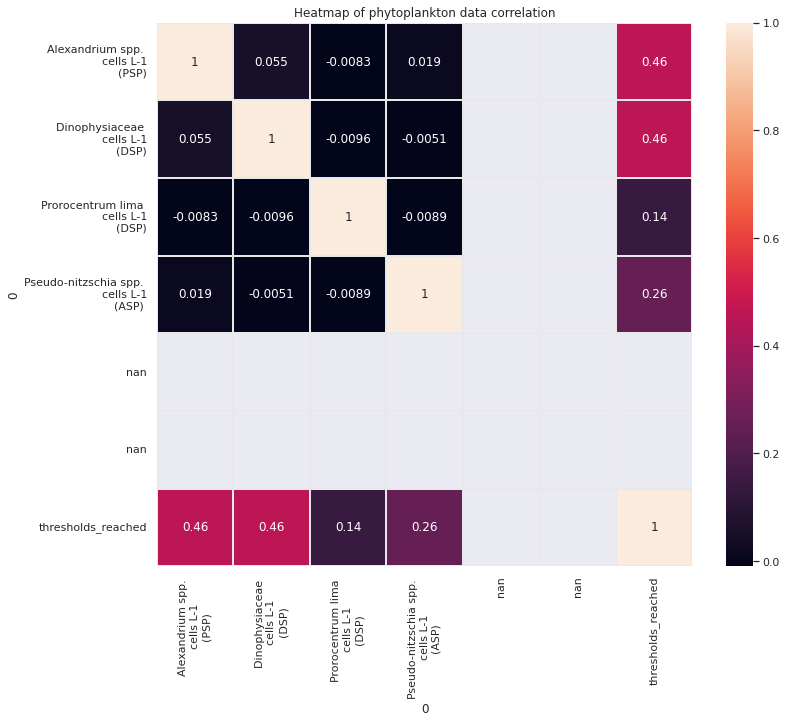

In [74]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, ax=ax, linewidths=1, linecolor='#e8e8e8')
plt.title('Heatmap of phytoplankton data correlation')